In [1]:
import os, sys, json

In [2]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["HADOOP_INSTALL"] = "/home/hadoop/hadoop"
os.environ["HADOOP_HOME"] = os.environ["HADOOP_INSTALL"]
os.environ["HADOOP_MAPRED_HOME"] = os.environ["HADOOP_INSTALL"]
os.environ["HADOOP_COMMON_HOME"] = os.environ["HADOOP_INSTALL"]
os.environ["HADOOP_HDFS_HOME"] = os.environ["HADOOP_INSTALL"]
os.environ["HADOOP_YARN_HOME"] = os.environ["HADOOP_INSTALL"]
os.environ["HADOOP_CONF_DIR"] = os.path.join(os.environ["HADOOP_INSTALL"], "/etc/hadoop")
os.environ["SPARK_HOME"] = "/home/hadoop/spark"
sys.path.insert(0, os.path.join(os.environ["SPARK_HOME"], "python"))
sys.path.append(os.path.join(os.environ["SPARK_HOME"], "python/lib/py4j-0.10.9.2-src.zip"))

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("HelloLines") \
    .config("spark.executor.instances", "2") \
    .config("spark.executor.cores", "2") \
    .config("spark.executor.memory", "1024M") \
    .getOrCreate()
sc = spark.sparkContext
print(sc.uiWebUrl)

2023-10-09 12:01:49,488 WARN util.Utils: Your hostname, cloud resolves to a loopback address: 127.0.2.1; using 192.168.121.62 instead (on interface eth0)
2023-10-09 12:01:49,489 WARN util.Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2023-10-09 12:01:50,661 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


http://192.168.121.62:4040


In [4]:
def getDataFromHDFS(filePath):
   try:
      return spark.read.options(header='True').csv(filePath)
   except Exception as e:
      return -1

In [5]:
rdd = sc.textFile("hdfs:/datasets/spotify/tracks.json")

In [6]:
rdd2 = rdd.map(lambda x: json.loads(x))
dfp = rdd2.toDF()

1. Statistics about songs duration

1.1 - Generate a table containing the minimum, average and maximum duration, in milliseconds, of the songs in the dataset.

In [7]:
aggregates = getDataFromHDFS('q1.1.csv')
if aggregates == -1:
    min = dfp.agg({ 'duration_ms' : 'min' })
    avg = dfp.agg({ 'duration_ms' : 'avg' })
    max = dfp.agg({ 'duration_ms' : 'max' })
    aggregates = min.join(avg)
    aggregates = aggregates.join(max)
    aggregates.write.option("header", True).csv('./q1.1.csv')
aggregates.show()

+---+------------------+--------+
|  0|234408.54976216817|10435467|
+---+------------------+--------+
+---+------------------+--------+



1.2 - Compute the first and third quartiles (denoted Q1​ and Q3​), as well as the interquartile range (IRQ) (Q3​−Q1​).

In [8]:
quantiles = dfp.approxQuantile("duration_ms", [0.25, 0.75], 0)
q1, q3 = quantiles[0], quantiles[1]
q1, q3

(198333.0, 258834.0)

1.3 - Compute the set of songs with durations that are not outliers, as defined by the IQRR methodology. In other words, identify all songs with duration xx such that Q1 − 1.5 × IQR < x < Q3 + 1.5 × IQR.

In [14]:
def iqr_outlier_treatment(df, factor=1.5):
    iqr = q3 - q1
    print(iqr)

    # Define the upper and lower bounds for outliers
    lower_bound = q1 - factor * iqr
    upper_bound = q3 + factor * iqr

    df_not_outliers = df.filter((df["duration_ms"] > lower_bound) & (df["duration_ms"] < upper_bound))
    df_outliers = df.subtract(df_not_outliers)

    return df_not_outliers, df_outliers

In [15]:
# not_outliers
df_treated = iqr_outlier_treatment(dfp)
df_not_outliers = df_treated[0]
df_not_outliers.count()

# not_outliers_aggregates = getDataFromHDFS('q1.3.csv')
# if not_outliers_aggregates == -1:
#     min = df_not_outliers.agg({ 'duration_ms' : 'min' })
#     avg = df_not_outliers.agg({ 'duration_ms' : 'avg' })
#     max = df_not_outliers.agg({ 'duration_ms' : 'max' })
#     not_outliers_aggregates = min.join(avg)
#     not_outliers_aggregates = not_outliers_aggregates.join(max)
#     not_outliers_aggregates.write.option("header", True).csv('./q1.3.csv')
# not_outliers_aggregates.show()

60501.0


10200555

1.4 - Using the IQRR methodology, how many songs would be considered outliers and removed from analysis? Generate a new table containing the minimum, average and maximum duration of the remaining songs.

In [11]:
# outliers
df_outliers = df_treated[1]
#df_outliers.count()

outliers_aggregates = getDataFromHDFS('q1.4.csv')
if outliers_aggregates == -1:
    min = df_outliers.agg({ 'duration_ms' : 'min' })
    avg = df_outliers.agg({ 'duration_ms' : 'avg' })
    max = df_outliers.agg({ 'duration_ms' : 'max' })
    outliers_aggregates = min.join(avg)
    outliers_aggregates = outliers_aggregates.join(max)
    outliers_aggregates.write.option("header", True).csv('./q1.4.csv')
outliers_aggregates.show()

+---+-----------------+--------+
|  0|371193.3242420833|10435467|
+---+-----------------+--------+
+---+-----------------+--------+



2. Finding the most popular artists over time

Finding popular artists can be interesting to analyze user tendencies and to inform organizations preparing advertising campaigns. In this task, find the five most popular artists ranked by the number of playlists they appear in. Create a chart that shows the number of playlists containing each of these five artists over the years. Consider that an artist is present in a playlist after each playlist's last modification date.

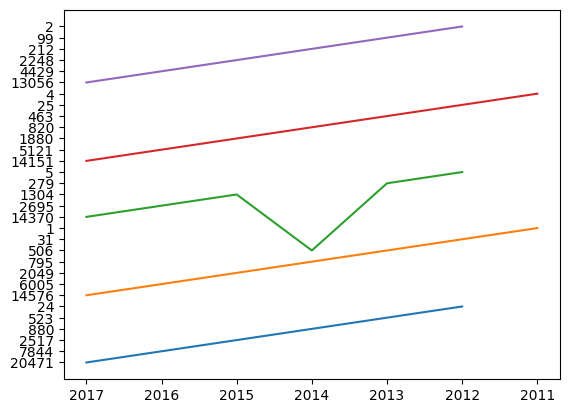

In [12]:
rdd3 = sc.textFile("hdfs:/datasets/spotify/playlist.json")
rdd3 = rdd3.map(lambda x: json.loads(x))
dfplaylists = rdd3.toDF()

dfsuper = dfp.withColumnRenamed('pid', 'pid_playlist')
dfsuper = dfsuper.join(dfplaylists, dfsuper.pid_playlist == dfplaylists.pid, 'left')

#most popular artists by the number of playlists they appear in

from pyspark.sql.functions import countDistinct, col, year, from_unixtime

dfsuper = (dfsuper \
    .groupBy('artist_name', year(from_unixtime('modified_at')).alias('year')) \
    .agg(countDistinct('pid') \
    .alias('num_playlists')) \
    .orderBy(col('num_playlists').desc()))
top_artists = ["Drake", "Rihanna", "Kanye West", "The Weeknd", "Kendrick Lamar"]
top_artists_per_year = getDataFromHDFS('q2.csv')

if top_artists_per_year == -1:
    top_artists_per_year = dfsuper \
        .filter(col('artist_name').isin(top_artists))
    top_artists_per_year.write.option("header", True).csv('./q2.csv')

drake_yoy =  top_artists_per_year.where('artist_name="Drake"').toPandas()
rihanna_yoy = top_artists_per_year.where('artist_name="Rihanna"').toPandas()
kendrick_yoy = top_artists_per_year.where('artist_name="Kendrick Lamar"').toPandas()
kanye_yoy = top_artists_per_year.where('artist_name="Kanye West"').toPandas()
weeknd_yoy = top_artists_per_year.where('artist_name="The Weeknd"').toPandas()

import matplotlib.pyplot as plt

plt.plot(drake_yoy['year'], drake_yoy['num_playlists'])
plt.plot(rihanna_yoy['year'], rihanna_yoy['num_playlists'])
plt.plot(kendrick_yoy['year'], kendrick_yoy['num_playlists'])
plt.plot(kanye_yoy['year'], kanye_yoy['num_playlists'])
plt.plot(weeknd_yoy['year'], weeknd_yoy['num_playlists'])

3. Playlists's behavior

What is more common, playlists where there are many songs by the same artist or playlists with more diverse songs?

In [43]:
from pyspark.sql.functions import *
# playlists com mais musicas do mesmo artista vs playlists com mais musicas de artistas variados
# tem um atributo com num_artists (the total number of unique artists for the tracks in the playlist)

# groupBy pid da playlist, pelo artista e vê qnts musicas esse artista tem na playlist

group_cols = ["pid", "artist_name"]
# filtre pelas playlists pegando pelas com mais musica por artista/pegar o top artista mais frequente em cada playlist 
df_grouped = dfp.groupBy(group_cols).count().orderBy(desc("count"), "artist_name").collect()


# prevalence = total de musicas/total de musicas do artista mais frequente
# para cada artista no df_grouped pega num total de musicas na playlist/num de musicas do artista



In [42]:
df_grouped.count()

6133450

In [46]:
#dfp.summary().show()

In [44]:
cond = [dfp.pid == df_grouped.pid]
df = dfp.join(df_grouped['num_tracks'], cond).show()
df

AttributeError: 'list' object has no attribute 'pid'